# Building micrograd

In [ ]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
# help func for graph visualization
from graphviz import Digraph


def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    # dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % ( n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
# # sample func
# def f(x):
#   return 3*x**2 - 4*x + 5

## 1. micrograd

In [ ]:
# micrograd
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # gradient
    self._backward = lambda: None # backpropagation
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # += here: accumulate the grad based on chain rule
      # in case that the variable is used more than once
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def exp(self):
      x = self.data
      out = Value(math.exp(x), (self, ), 'exp')

      def _backward():
        self.grad += out.data * out.grad
      out._backward = _backward

      return out

  # nonlinearlities
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out


  def relu(self):
    out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

    def _backward():
        self.grad += (out.data > 0) * out.grad
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    # topological sort
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)


  def __rmul__(self, other): # other * self
    return self * other

  def __radd__(self, other): # other + self
    return self + other

  def __rsub__(self, other): # other - self
    return other + (-self)

  def __rtruediv__(self, other): # other / self
    return other * self**-1





# a = Value(2.0, label='a')
# b = Value(-3, label='b')
# c = Value(10, label='c')
# e = a*b; e.label = 'e'
# d = e + c; d.label = 'd'
# f = Value(-2.0, label='f')
# L = d * f; L.label = 'L'
# L

In [ ]:
a = Value(2.0)
b = Value(4.0)
a - 1

Value(data=1.0)

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# b = Value(8, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# do tanh manually
e = (2*n).exp()
o = (e - 1)/(e + 1)
o.label = 'o'
# do tanh directly
# o = n.tanh(); o.label = 'o'
o.backward()

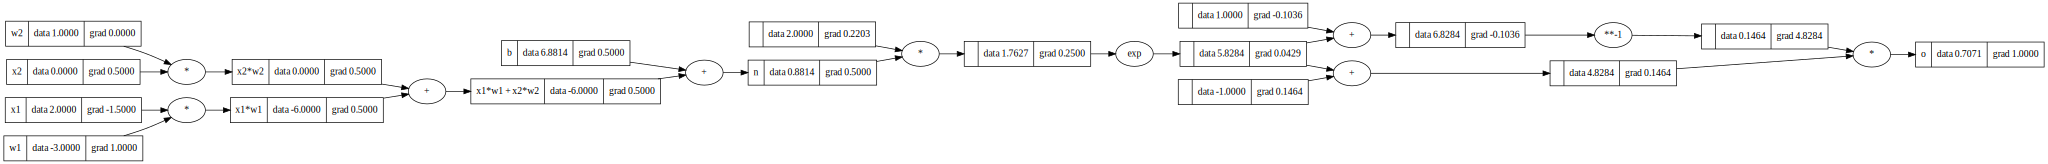

In [ ]:
draw_dot(o)

## 2. Implement in pytorch

In [ ]:
import torch

In [ ]:
# tensor in default in dtype float32
# convert to float64 to be consistent with python default
# by default leaf nodes do not require gradient,
# explicitly set requires_grad to True
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
o, o.data, o.data.item()

(tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>),
 tensor([0.7071], dtype=torch.float64),
 0.7071066904050358)

In [ ]:
o.item()

0.7071066904050358

## 3. Implement a NN with Value class

In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params


class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


# 3 input neurons, 2 layer of 4, 1 output
x = [2.0, 3.0, -0.1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6700512271285002)

In [ ]:
len(n.parameters())

41

In [ ]:
# 3 input neurons, 2 layer of 4, 1 output
x = [2.0, 3.0, -0.1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.41861566971071984)

In [ ]:
# give 4 samples
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [ ]:
# gradient descent optimization manually
for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  # simple loss func MSE
  # can be more complex one like cross entropy
  # and can support batches, and regularization
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  # set grad to zero before backward()
  # it's a common mistake :P
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  # simple stochastic grad descent
  for p in n.parameters():
    # gradient descent
    # constant learning rate here, can use learning rate decay
    # p.data += -0.01 * p.grad
    p.data += -0.05 * p.grad

  print(k, loss.data)


0 0.014452723405151057
1 0.014300220716126487
2 0.014150843924091125
3 0.014004498698838182
4 0.013861094449695188
5 0.013720544142599812
6 0.01358276412778692
7 0.013447673977376503
8 0.013315196332206135
9 0.013185256757301318
10 0.013057783605420295
11 0.012932707888153951
12 0.01280996315409717
13 0.01268948537364422
14 0.012571212829992021
15 0.012455086015965615
16 0.012341047536306254
17 0.012229042015088194
18 0.012119016007953853
19 0.012010917918876974


In [ ]:
# MSE
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.04002191305659488)

In [ ]:
# # MSE
# ypred = [n(x) for x in xs]
# loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
# loss

Value(data=5.2786358130916184)

In [ ]:
# MSE
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.0036707901180234818)

In [ ]:
loss.backward()

In [ ]:
# n.layers[0].neurons[0].w[0].grad
# n.layers[0].neurons[0].w[0].data
# draw_dot(loss)

In [ ]:
for p in n.parameters():
  # gradient descent
  # p.data += -0.01 * p.grad
  p.data += -0.1 * p.grad

In [ ]:
ypred

[Value(data=0.9571937512766755),
 Value(data=-0.9999887857721957),
 Value(data=-0.9999999894364114),
 Value(data=0.95712325732403)]

In [ ]:
n.parameters()

[Value(data=0.09379364165568649),
 Value(data=-0.9335291274847957),
 Value(data=2.8566114783633987),
 Value(data=0.8760372997264734),
 Value(data=1.4716369772830225),
 Value(data=0.29491908939867606),
 Value(data=-3.372831335401681),
 Value(data=0.34538533094701784),
 Value(data=-0.5203704530880665),
 Value(data=-2.7020054265318705),
 Value(data=2.5814220321584713),
 Value(data=-1.5056409411195844),
 Value(data=-10.54608193420264),
 Value(data=-0.5421659078452904),
 Value(data=-6.175116981187032),
 Value(data=-6.4441156600659335),
 Value(data=-5.9732846291699975),
 Value(data=0.2973950509218045),
 Value(data=-4.63547519994906),
 Value(data=-5.103449155160875),
 Value(data=2.0051004985978773),
 Value(data=-4.8957654539893385),
 Value(data=0.5782701675950357),
 Value(data=-2.3973978462383845),
 Value(data=-1.7195411905765288),
 Value(data=-0.6842235647544826),
 Value(data=2.814300899223589),
 Value(data=-1.4314153990285743),
 Value(data=1.4308805547601096),
 Value(data=3.531948543995653)

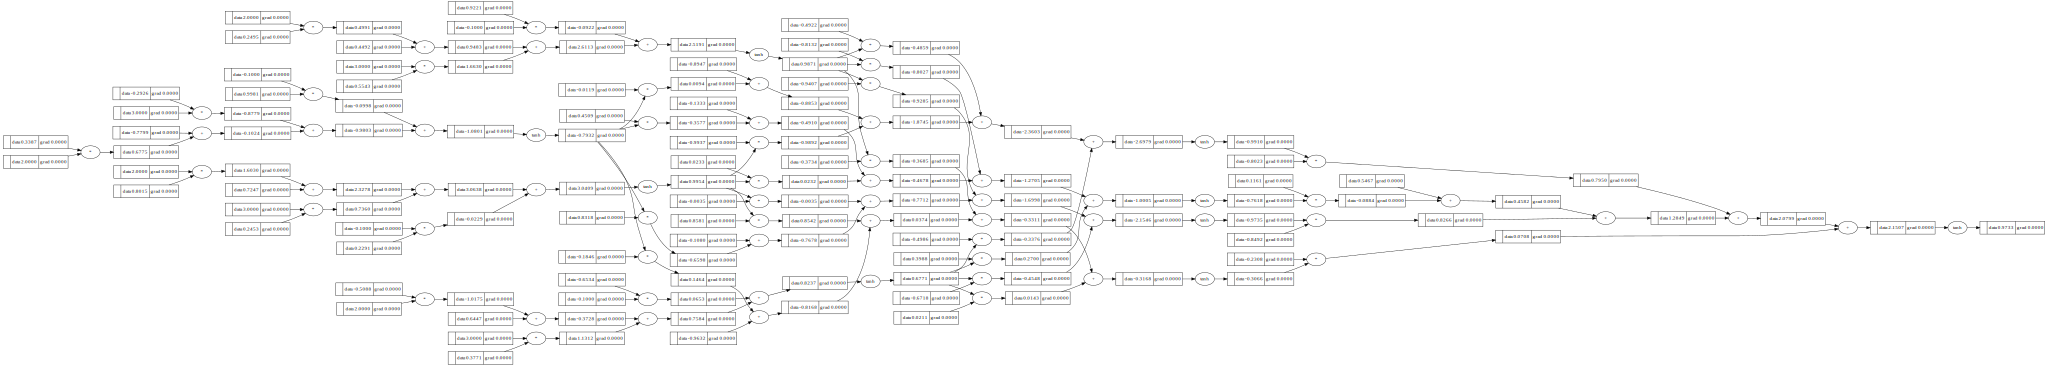

In [ ]:
draw_dot(n(x))

In [ ]:
# L.grad = 1
# f.grad = 4
# d.grad = -2
# c.grad = -2
# e.grad = -2
# a.grad = -2 * -3
# b.grad = -2 * -2

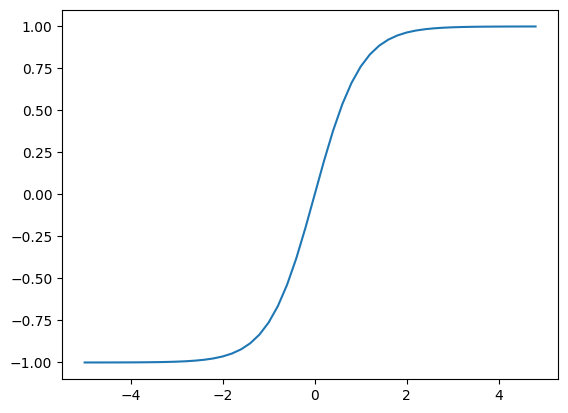

In [ ]:
# plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))

In [ ]:
# # call _backward() manually
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

In [ ]:
# o.grad = 1.0

# # topological sort
# topo = []
# visited = set()
# def build_topo(v):
#   if v not in visited:
#     visited.add(v)
#     for child in v._prev:
#       build_topo(child)
#     topo.append(v)
# build_topo(o)

# for node in reversed(topo):
#   node._backward()

In [ ]:
# topological sort
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
o.grad = 1
n.grad = 0.5  # do/dn = 1 - tanh(o)**2
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x2w2.grad
w1.grad = x1.data * x2w2.grad

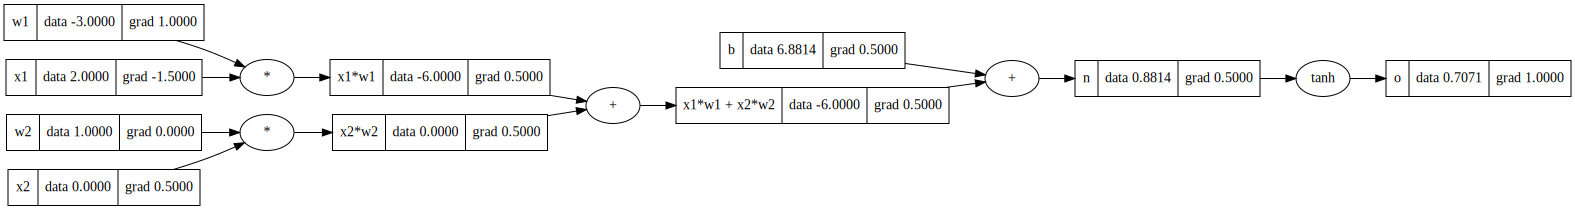

In [ ]:
draw_dot(o)